# Part 1: Data Description
## Sessions.csv
5 variables and 1,536 observations.
- hashedEmail (character): email address of a user after going through a hash function.
    - can be used to match an observation from sessions.csv to players.csv
    - can be used to identify multiple sessions from the same player
- start_time (character) and end_time (character)
    - the format ("DD/MM/YYYY time") makes it undity
        - should each be split up into two variables each (i.e. start_date and start_time)
- original_start_time (double) and original_end_time (double):
    - this is in unix time
    - all observations are 1.71E+12, 1.72E+12, and 1.73E+12
        - these 3 observations represent all dates from Jan 11 to Dec 24, 2024
        - start_time and end_time are more precise and should be used instead 
## Players.csv
9 variables and 197 observations.
- experience (character): past minecraft experience level (self-reported)
- subscribe (logical): whether or not they are subscribed to plaicraft.ai's email updates
- hashedEmail (character): 
    - the only shared variable between sessions.csv and players.csv 
- played_hours (double): number of hours played on plaicraft.ai
- name (character): chosen in-game name 
- gender (character)
- Age (double)
- individualId (logical) and organizationName (logical): relics left over from an older system used for identifying players
    - every single value for these variables is NA


# Part 2: Question

## How do a player's age, gender, experience level, and typical time of week they start playing affect the total amount of hours they log playing plaicraft.ai?

This is important for trying to figure out which demographics of players to advertise to, and for trying to figure out **when** to send out email blasts to try to convince those players to play more.

In the sessions dataset:
- Total time played per session will come from end_time - start_time
- Weekday_played (i.e. Monday) and time_of_day_played (i.e. Morning) will come from start_time
- We'll pivot the data so that the sessions dataset includes one observation per hashed email with typical_day_played and typical_time_of_day_played

The rest of the variables will come from binding the columns of the sessions and players datasets

# Part 3: Exploratory Data Analysis and Visualization

In [1]:
library(tidyverse)
library(RColorBrewer)
options(repr.plot.width = 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
url1 <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
url2 <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
players_data <- read_csv(url1)
sessions_data <- read_csv(url2)

#separate the start_time into two columns, for tidy data
sessions_data <- sessions_data |> separate_wider_delim(cols = start_time, delim = " ", 
                                      names = c("start_date", "start_time"),
                                                cols_remove = TRUE)
#separate the end_time into two columns, for tidy data
sessions_data <- sessions_data |> separate_wider_delim(cols = end_time, delim = " ", 
                                      names = c("end_date", "end_time"),
                                                cols_remove = TRUE)

#get rid of the two entire columns that have NA as every data point
players_data <- players_data |> select(-individualId) |> select(-organizationName)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


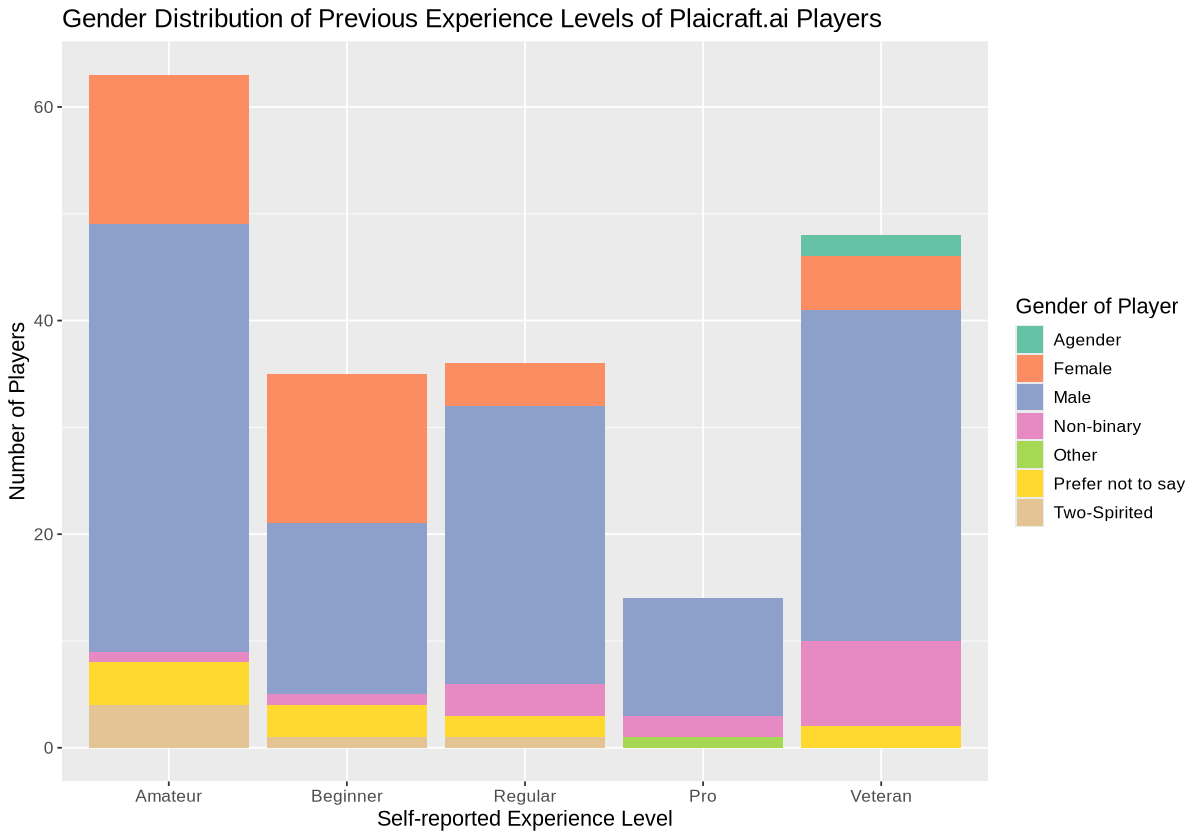

In [3]:
experiences_in_order <- c("Amateur", "Beginner", "Regular", "Pro", "Veteran")
experience_gender_visualization <- ggplot(players_data, aes(x=factor(experience, experiences_in_order), fill=gender)) + 
                        geom_bar(stat="count") + 
                        labs(x = "Self-reported Experience Level", 
                             y = "Number of Players", 
                             fill = "Gender of Player", 
                             title = "Gender Distribution of Previous Experience Levels of Plaicraft.ai Players") +
                        theme(text = element_text(size = 13)) + 
                        scale_fill_brewer(palette = "Set2") 
experience_gender_visualization

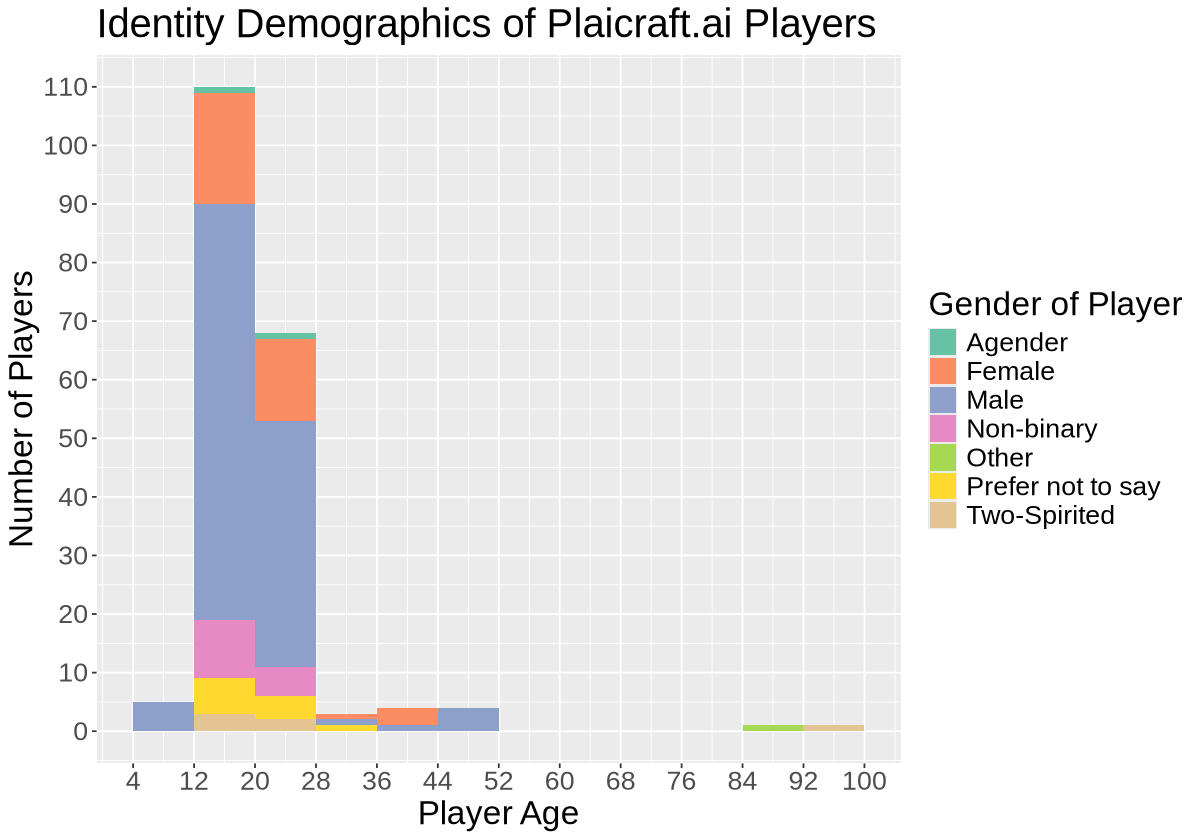

In [4]:

age_gender_visualization <- ggplot(players_data, aes(x=age, fill=gender)) + geom_histogram(binwidth = 8) + 
                        labs(x = "Player Age", y = "Number of Players", fill = "Gender of Player", title = "Identity Demographics of Plaicraft.ai Players") +
                        theme(text = element_text(size = 20)) + 
                        scale_fill_brewer(palette = "Set2") +
                        scale_x_continuous(breaks=seq(4,100,8)) +
                        scale_y_continuous(breaks=seq(0,115,10)) 
age_gender_visualization

The two above graphs show that we don't have enough data points for most genders. To combat this, we should use the gender classifications "Male", "Female", and "Other".

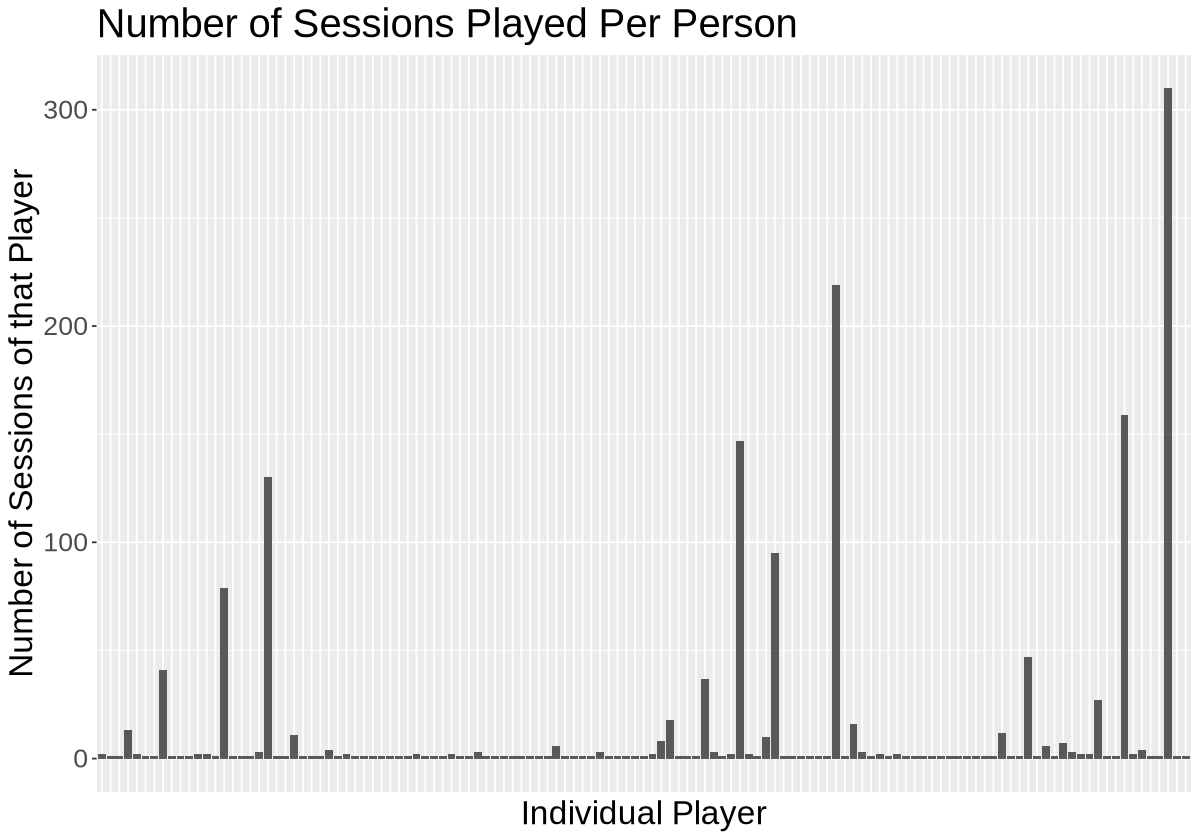

In [5]:
session_number_visualization <- ggplot(sessions_data, aes(x=hashedEmail)) + 
                        geom_bar(stat = "count") + 
                        labs(x = "Individual Player", y = "Number of Sessions of that Player", title = "Number of Sessions Played Per Person") +
                        theme(text = element_text(size = 20)) +
                        theme(axis.text.x=element_blank(), axis.ticks.x=element_blank())
session_number_visualization

A few players play *a lot* of sessions. It's only important to note that they play a lot--we don't want the exact insanely-high number of hours they play to skew the data--so we should choose a classification model.

# Methods and Plan
We will use KNN classification. 

In order to know who to recruit, what's more important:
1. predicting if a player "won't play at all", "will play a little", or "will play a lot"
    - these are categories
2. predicting "this player will likely play 256 hours"?

For recruiting players, the first one is more important. As such, we want to use classification rather than regression.

We are assuming that the response variable is categorical, the data will be standardized, and the data is relatively balanced between categories.

A limitation is that if we don't have balanced training data, our model won't be the best at predicting.

To select our model: We will use cross validation and tune K so that the accuracy metric is the highest. We will cross-validate with 5 folds to ensure that outliers due to unrepresentative testing-training splits won't negatively affect our choice of K.